In [1]:
import pennylane as qml
from matplotlib import pyplot as plt
import numpy as np
import scipy
import networkx as nx
import copy

In [2]:
qubit_number = 4
qubits = range(qubit_number)

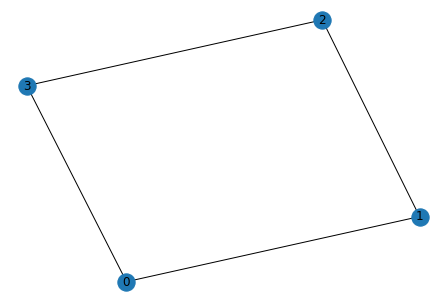

In [3]:
ising_graph=nx.cycle_graph(qubit_number)
nx.draw(ising_graph,with_labels=True)

In [4]:
print("edges",ising_graph.edges)
print("nodes",ising_graph.nodes)
Nodes=np.array(ising_graph.nodes)
Nodes

edges [(0, 1), (0, 3), (1, 2), (2, 3)]
nodes [0, 1, 2, 3]


array([0, 1, 2, 3])

In [5]:
A=np.array(nx.adjacency_matrix(ising_graph).todense())
print(A)

[[0 1 0 1]
 [1 0 1 0]
 [0 1 0 1]
 [1 0 1 0]]


In [6]:
# Quantum data: set of training and test set of input and output quantum states

In [7]:
target_edge_weights = [0.56, 1.24, 1.67, -0.79]
target_node_weights = [-1.44, -1.43, 1.18, -0.93]

In [8]:
'''
The collection of quantum data needed to run the QGRNN has two components: 

(i) copies of a low-energy state, and
(ii) a collection of time-evolved states

'''

'\nThe collection of quantum data needed to run the QGRNN has two components: \n\n(i) copies of a low-energy state, and\n(ii) a collection of time-evolved states\n\n'

In [9]:
low_energy_state = [ (-0.054661080280306085 + 0.016713907320174026j),
    (0.12290003656489545 - 0.03758500591109822j),
    (0.3649337966440005 - 0.11158863596657455j),
    (-0.8205175732627094 + 0.25093231967092877j),
    (0.010369790825776609 - 0.0031706387262686003j),
    (-0.02331544978544721 + 0.007129899300113728j),
    (-0.06923183949694546 + 0.0211684344103713j),
    (0.15566094863283836 - 0.04760201916285508j),
    (0.014520590919500158 - 0.004441887836078486j),
    (-0.032648113364535575 + 0.009988590222879195j),
    (-0.09694382811137187 + 0.02965579457620536j),
    (0.21796861485652747 - 0.06668776658411019j),
    (-0.0027547112135013247 + 0.0008426289322652901j),
    (0.006193695872468649 - 0.0018948418969390599j),
    (0.018391279795405405 - 0.005625722994009138j),
    (-0.041350974715649635 + 0.012650711602265649j),]

In [10]:
a = np.array([1+2j,3+4j])
b = np.array([5+6j,7+8j])

print(np.dot(np.transpose(np.conj(a)),b))
# np.dot doesn't use complex conjugate of 'a'
print(np.vdot(a,b))

(70-8j)
(70-8j)


In [11]:
# creating the hamiltonian matrix in my own way

# use it for further works instead of the pennylane's one

def H_matrix(graph,edge_weights,node_wieghts,no_of_qubits):
    # edge_weights= $\theta_1$ parameters for interaction terms
    # node_weights= $\theta_2$ parameters for single qubit terms
    
    full_matrix=np.zeros((2**no_of_qubits,2**no_of_qubits))
    
    # creating the two qubit interation terms:
    for i,edge in enumerate(graph.edges):
        
        zz_int=1
        
        for qubit in range(no_of_qubits):
            
            if qubit in edge:
                # for only ZZ interaction but it can be generalized to XX/YY interaction
                zz_int=np.kron(zz_int,qml.PauliZ.matrix)
                
            else:
                zz_int=np.kron(zz_int,np.identity(2))
                
        full_matrix+=edge_weights[i]*zz_int
        
        
    # store the nodes in an array "Nodes"  
    Nodes=np.array(ising_graph.nodes)
    # creating individual qubit energy terms:
    for node in Nodes:
        
        z_int = x_int = 1
        
        for qubit in range(no_of_qubits):
            
            
            if node==qubit:
                
                z_int=np.kron(z_int,qml.PauliZ.matrix)
                x_int=np.kron(x_int, qml.PauliX.matrix)
            else:
                z_int=np.kron(z_int,np.identity(2))
                x_int=np.kron(x_int,np.identity(2))
      
        full_matrix+=node_wieghts[node]*z_int+x_int
    return full_matrix

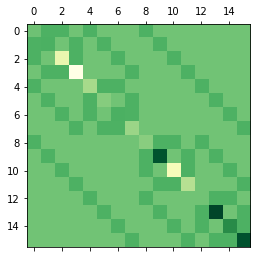

In [12]:
target_weights = [0.56, 1.24, 1.67, -0.79]
target_bias = [-1.44, -1.43, 1.18, -0.93]
H=H_matrix(ising_graph,target_weights,target_bias,qubit_number)
plt.matshow(H, cmap="YlGn")
plt.show()

In [13]:
result1=np.vdot(low_energy_state,np.dot(np.transpose(np.conj(H)),low_energy_state))

Ground_state_energy=np.real_if_close(result1)

print(f"Ground state energy:{Ground_state_energy}")

Ground state energy:-7.244508985189116


In [14]:
print(f"Minimum eigen energy:{np.real_if_close(min(np.linalg.eig(H)[0]))}")

Minimum eigen energy:-7.33068966129124


In [15]:
# the time evolution operator which will help to evolve the ground state

def unitary_evolution(hamiltonian,qubits,time):
    # first the hamiltonian should be created with a set of parameters then we have to call during optimization
    U=scipy.linalg.expm(-1j*hamiltonian*time)
    '''
     note that here we are calculating the exact exponentiation of hamiltonian and this is not the simulated unitary using 
     trotterizationthe, reason of doing that is to define the cost, later, as fidelity between actual evolved and simulated 
     evoled state
    '''
    qml.QubitUnitary(U,wires=qubits)

In [16]:
# defining QGRNN layer to simulate the exact exponential "unitary_evolution()" using trotterization

def QGRNN_layer(edge_weights,node_weights,graph,qubits,delta):
    '''
    here we can define the z⊗z from scratch like toffoli, fredkin case but we will directly calculate that from inbuild func.
    Parameters should be divided by n, where n=trotter steps
    '''
    # defining the layer for two qubit z⊗z interactions
    for i,edge in enumerate(graph.edges):
        qml.MultiRZ(2*edge_weights[i]*delta,wires=(edge[0],edge[1]))    # it create z⊗z interactions for all the edges
        
        # to know why the actual parameters are multiplied by 2, see the notes for qml.MultiRZ() in pennylane and see the form
        
    # defining the layer for single qubit energy
    for i,node in enumerate(graph.nodes):
        qml.RZ(2*node_weights[i]*delta,wires=node)
        qml.RX(2*delta,wires=node)

In [17]:
for edge in ising_graph.edges:
    print(edge[0],edge[1])

0 1
0 3
1 2
2 3


In [18]:
def Swap_test(control_wire,target_register1,target_register2):
    
    qml.Hadamard(wires=control_wire)
    for wire1,wire2 in zip(target_register1,target_register2):
        qml.CSWAP(wires=(control_wire,wire1,wire2))
    qml.Hadamard(wires=control_wire)


In [19]:
reg1=tuple(range(1,qubit_number+1))
reg2=tuple(range(1+qubit_number,2*qubit_number+1))
print(reg1+reg2)

control=0 # the control qubit in swap operation

(1, 2, 3, 4, 5, 6, 7, 8)


edges-> [(5, 6), (5, 7), (5, 8), (6, 7), (6, 8), (7, 8)]


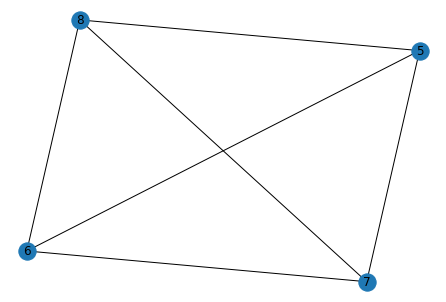

In [20]:
init_guess_ising_graph=nx.complete_graph(reg2)
nx.draw(init_guess_ising_graph,with_labels=True)
print("edges->",init_guess_ising_graph.edges)

In [21]:
qgrnn_dev = qml.device("default.qubit", wires=2 * qubit_number + 1) # 8 register qubits and 1 control qubit for swap test

In [22]:
@qml.qnode(qgrnn_dev)
def full_QGRNN_layer(edge_weights,node_weights,t):
    '''
    As mentioned in the website QGRNN consists of two register : 1. The actual set of input/output states from exp(-iHt)
    and 2. Simulated set of input/output states and finally we have to minimize the fidelity
    '''
    
    # The two input registers reg1 and reg2 will contain the same initial state i.e. the "low-energy-state".
    qml.QubitStateVector(np.kron(low_energy_state,low_energy_state),wires=reg1+reg2)
    
    unitary_evolution(H,reg1,t) # exp(-iHt)|ψ(0)>
    
    trotter_steps=t/delta  # see this link : 
                           # https://en.wikipedia.org/wiki/Time-evolving_block_decimation#The_Suzuki-Trotter_expansion
                           # smaller the value of delta in trotter formula -> more accurate will be the approximation
                           # according to that formula trotter step is a function of time 'T' and 'delta'
                
    for depth in range(int(trotter_steps)):
        QGRNN_layer(edge_weights,node_weights,init_guess_ising_graph,qubit_number,delta)
    
    # the wires are updated
    # applying swap test to the last 8 qubits
    Swap_test(control,reg1,reg2)
    
    return qml.expval(qml.PauliZ(control))

In [23]:
'''
@qml.qnode(qgrnn_dev)
def Swap_test1(edge_weights,node_weights,t):
    
    full_QGRNN_layer(edge_weights,node_weights,t)
    qml.Hadamard(wires=control)
    for wire1,wire2 in zip(reg1,reg2):
        qml.CSWAP(wires=(control,wire1,wire2))
    qml.Hadamard(wires=control)
    
    return qml.expval(qml.PauliZ(control))
    
'''

'\n@qml.qnode(qgrnn_dev)\ndef Swap_test1(edge_weights,node_weights,t):\n    \n    full_QGRNN_layer(edge_weights,node_weights,t)\n    qml.Hadamard(wires=control)\n    for wire1,wire2 in zip(reg1,reg2):\n        qml.CSWAP(wires=(control,wire1,wire2))\n    qml.Hadamard(wires=control)\n    \n    return qml.expval(qml.PauliZ(control))\n    \n'

In [24]:
times_sampled = np.random.rand(15)

In [25]:
times_sampled

array([0.9623003 , 0.66587498, 0.63901611, 0.73221233, 0.4145642 ,
       0.76687831, 0.54273758, 0.68810418, 0.70463878, 0.19791337,
       0.7593822 , 0.4214516 , 0.4452915 , 0.56523669, 0.33884121])

In [26]:
N = 15  # The number of pieces of quantum data that are used for each step
max_time = .1  # The maximum value of time that can be used for quantum data

In [27]:
#rng = np.random.default_rng(seed=42)

def cost_function(weight_params, bias_params):

    # Randomly samples times at which the QGRNN runs
    times_sampled =np.random.rand(N)*max_time

    # Cycles through each of the sampled times and calculates the cost
    total_cost = 0
    for dt in times_sampled:
        result = full_QGRNN_layer(weight_params, bias_params,dt)
        total_cost += -1 * result

    return total_cost / N

In [28]:




weights = (np.random.rand(len(init_guess_ising_graph.edges))-0.5)
bias = (np.random.rand(qubit_number)-0.5)

initial_weights = copy.copy(weights)
initial_bias = copy.copy(bias)

In [42]:
delta=0.01 # this delta should be choosen very carefully for better guess, check the ans for a dry run of the cost below

In [43]:
cost_function(weights, bias)

tensor(-0.99969658, requires_grad=True)

In [31]:
costarr=[]
params_edge=[]
params_node=[]

In [32]:
steps = 100

In [44]:
optimizer = qml.AdamOptimizer(stepsize=0.01)

for i in range(0, steps+1):
    (weights, bias), cost = optimizer.step_and_cost(cost_function, weights, bias)

    # Prints the value of the cost function
    if i % 10 == 0:
        print(f"Cost at Step {i}: {cost}")
        costarr.append(cost)
        params_edge.append(weights)
        params_node.append(bias)
        #print(f"Weights at Step {i}: {weights}")
        #print(f"Bias at Step {i}: {bias}")
        #print("---------------------------------------------")

Cost at Step 0: -0.9997273324401199
Cost at Step 10: -0.9997105551497351
Cost at Step 20: -0.9997796340971948
Cost at Step 30: -0.9998093657002154
Cost at Step 40: -0.9998586247590843
Cost at Step 50: -0.9998919972657355
Cost at Step 60: -0.9999052100272562
Cost at Step 70: -0.9998821696724984
Cost at Step 80: -0.9999226426042157
Cost at Step 90: -0.999954390465177
Cost at Step 100: -0.9999420848087713


In [34]:
# above can be considered as best as the fidelity is above 0.99 for t~1

In [35]:
weights_test=np.array([5.75810409e-01,  4.17373794e-02 , 1.33385607e+00  ,1.80469466e+00,
 -1.37560830e-03, -8.39439431e-01])
bias_test=np.array([-1.34861394 ,-1.31269908 , 0.97854738, -1.05489467])

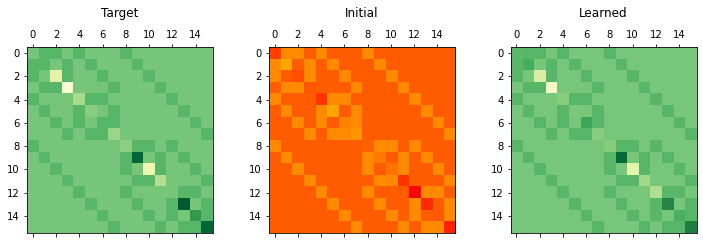

In [45]:
new_ham_matrix = H_matrix(nx.complete_graph(qubit_number),  weights, bias,
    qubit_number
)

init_ham = H_matrix(nx.complete_graph(qubit_number),  initial_weights, initial_bias,
    qubit_number
)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))

axes[0].matshow(H, vmin=-7, vmax=7, cmap="YlGn")
axes[0].set_title("Target", y=1.13)

axes[1].matshow(init_ham, vmin=-7, vmax=7, cmap="hot")
axes[1].set_title("Initial", y=1.13)

axes[2].matshow(new_ham_matrix, vmin=-7, vmax=7, cmap="YlGn")
axes[2].set_title("Learned", y=1.13)

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

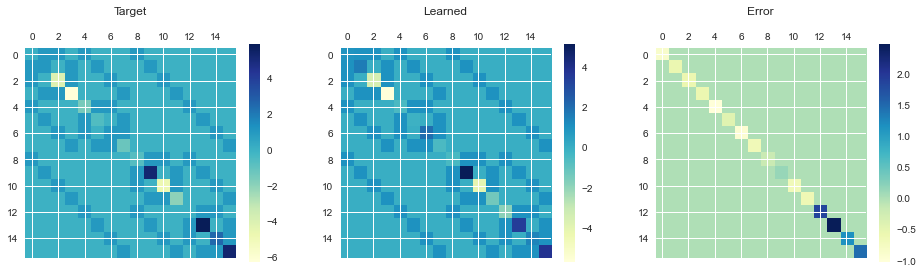

In [54]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 4))

ax1, ax2 ,ax3 = axes

im1 = ax1.matshow(H,cmap="YlGnBu")
ax1.set_title("Target", y=1.13)

im2 = ax2.matshow(new_ham_matrix,cmap="YlGnBu")
ax2.set_title("Learned", y=1.13)

diff_matrix= H-new_ham_matrix

im3 = ax3.matshow(diff_matrix,cmap="YlGnBu")
ax3.set_title("Error", y=1.13)


fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)

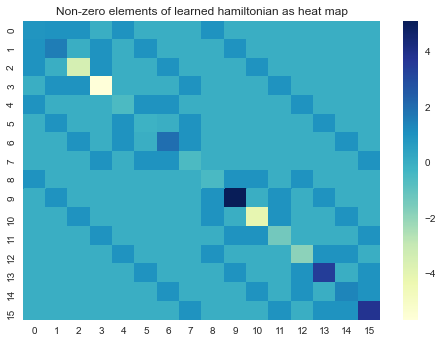

In [57]:
import seaborn
seaborn.heatmap(new_ham_matrix,cmap="YlGnBu")
plt.title("Non-zero elements of learned hamiltonian as heat map")
plt.show()

In [46]:
# Function to find the fidelity between two unitaries
def Fidelity(rho1,rho2):
    if rho1.shape!=rho2.shape:
        raise ValueError("Dimension of both matrices must be same")
    return (np.abs(np.trace(np.dot(np.transpose(np.conj(rho1)),rho2)))/len(rho1))

In [49]:
t=0.1
rho1=scipy.linalg.expm(-1j*new_ham_matrix*t)
rho2=scipy.linalg.expm(-1j*H*t)
print("Fidelity between the actual and the optimized evolution at time 0.1 is :",Fidelity(rho2,(rho1)))

Fidelity between the actual and the optimized evolution at time 0.1 is : 0.9943480106143281


In [50]:
print("learned weights",weights)
print("target weights",target_weights)
print("learned bias",bias)
print("target bias",target_bias)

learned weights [ 0.01316567  0.19557344  1.23168377  1.72327075 -0.07206067 -0.71574858]
target weights [0.56, 1.24, 1.67, -0.79]
learned bias [-0.73727048 -0.94171785  1.00312359 -0.77524066]
target bias [-1.44, -1.43, 1.18, -0.93]


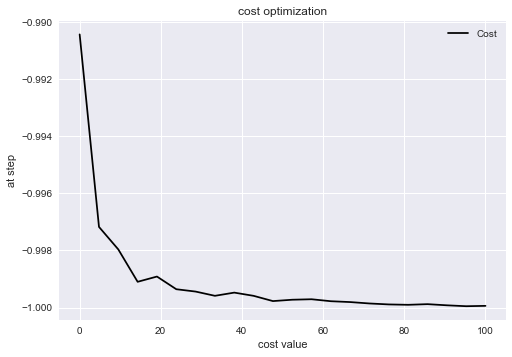

In [52]:
plt.style.use("seaborn")
plt.plot(np.linspace(0,100,22),costarr,"black",label="Cost")
plt.xlabel("cost value")
plt.ylabel("at step")
plt.title("cost optimization")
plt.legend()
plt.show()